# UK Roads

Load in a HUGE file of all roads. Simplify it to just the major ones.

## Code setup

In [1]:
import os
import geopandas as gpd
import io
import fiona
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Load roads data

In [5]:
path_to_roads = os.path.join('.', 'major_roads_with_short_names.geojson')

gdf_short_roads = gpd.read_file(path_to_roads)
gdf_short_roads = gdf_short_roads.set_index('roadNumber')

In [6]:
gdf_short_roads.head()

,function,geometry
roadNumber,,
A1,A Road,"MULTILINESTRING Z ((327223 674416 0, 327274.18..."
A1(M),Motorway,"MULTILINESTRING Z ((428374.35 555308.9 0, 4283..."
A10,A Road,"MULTILINESTRING Z ((563188.12 317320.18 0, 563..."
A11,A Road,"MULTILINESTRING Z ((622675.76 307842.13 0, 622..."
A12,A Road,"MULTILINESTRING Z ((597183 225531 0, 597170.5 ..."


## Simplify shapes

In [140]:
gdf_simplified_lines = gdf_short_roads.copy()
gdf_simplified_lines['geometry'] = gdf_simplified_lines['geometry'].simplify(tolerance=1000000) 

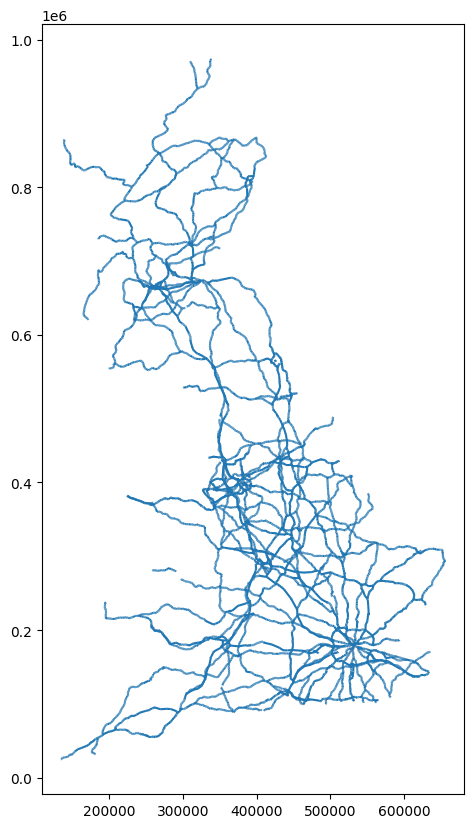

In [141]:
fig, ax = plt.subplots(figsize=(8, 10))

gdf_simplified_lines.plot(ax=ax)

plt.show()

Save this to file:

In [142]:
gdf_simplified_lines[['function', 'geometry']].to_file('major_roads_with_short_names_simplified.geojson')

File size is now 8MB.

| tolerance | File size |
| --- | --- |
| 10 | 9.2MB |
| 100 | 7.8MB |
| 500 | 7.7MB |
| 1000 | 7.7MB |
| 5000 | 7.7MB |
| 10000 | 7.7MB |
| 100000 | 7.7MB |
| 1000000 | 7.7MB |

There seems to be a limit in how much simplify() can do.

## Simplify round 2

In [134]:
gdf_simplify2 = gdf_short_roads.copy()

for ind in gdf_simplify2.index.values:
    gdf_simplify2.loc[ind, 'geometry'] = gdf_simplify2.loc[ind, 'geometry'].simplify(100.0)

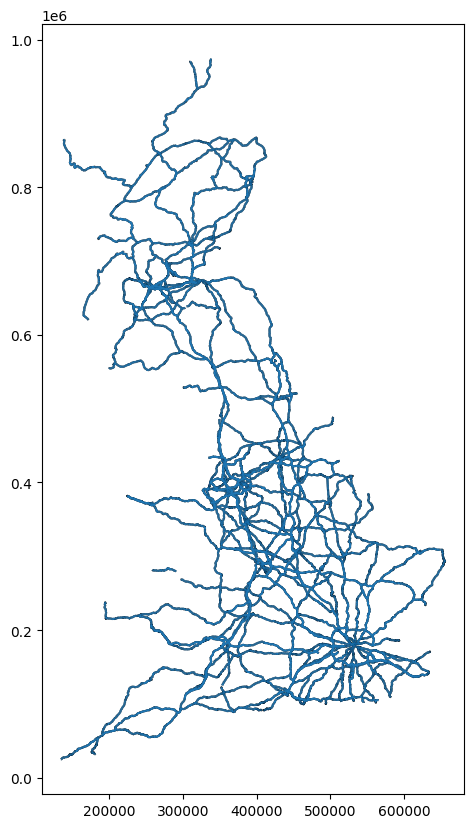

In [135]:
fig, ax = plt.subplots(figsize=(8, 10))

gdf_short_roads.plot(ax=ax, color='k')
gdf_simplify2.plot(ax=ax)

plt.show()

Save this to file:

In [136]:
gdf_simplify2[['function', 'geometry']].to_file('major_roads_with_short_names_simplified2.geojson')

Starting file size: 21.8MB.

| tolerance | File size |
| --- | --- |
| 0.5 | 12.4MB |
| 2.0 | 11.7MB |
| 10 | 9.2MB |
| 100 | 7.8MB |

I suspect this is using the exact same algorithm as the geopandas simplify(). The file sizes are identical.


## How many line segments are there?

In [7]:
dict_segments = {}

for i in gdf_short_roads.index:
    geo = gdf_short_roads.loc[i, 'geometry']
    if geo.geom_type == 'LineString':
        l = 1
    elif geo.geom_type == 'MultiLineString':
        l = len(geo.geoms)
    else:
        l = 0
    dict_segments[i] = l

In [8]:
df_segments = pd.DataFrame(dict_segments.values(), index=dict_segments.keys()).sort_values(by=0)

df_segments

,0
A66(M),5
A308(M),5
A48(M),5
A823(M),6
M49,7
...,...
A4,1993
A5,2037
A40,2140
A38,3170


Probably don't need thousands of segments per road!

Can adjacent segments be linked up somehow?

In [26]:
gdf_merged = gdf_short_roads.copy()

gdf_merged['geometry'] = gdf_merged['geometry'].line_merge()

In [31]:
print(len(gdf_short_roads.loc['A6', 'geometry'].geoms))
print(len(gdf_merged.loc['A6', 'geometry'].geoms))

3428
601


Check the results for the longest road:

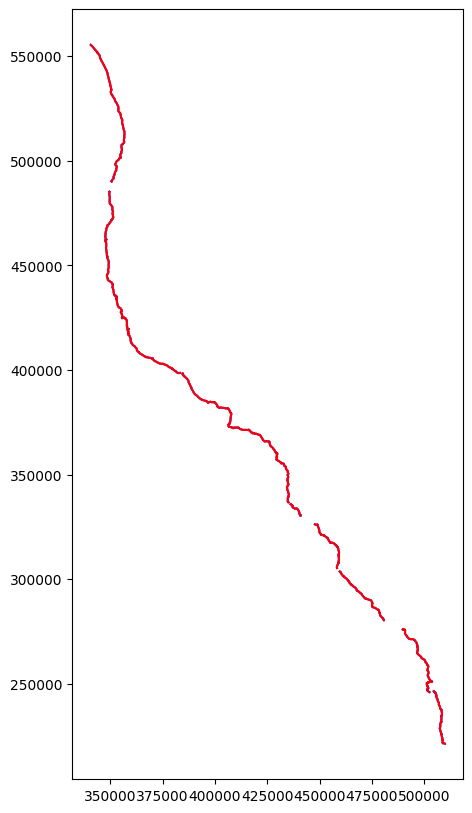

In [27]:
fig, ax = plt.subplots(figsize=(8, 10))

geo = gdf_short_roads.loc[['A6']]#, 'geometry']
geo.plot(ax=ax, color='b')

geo2 = gdf_merged.loc[['A6']]#, 'geometry']
geo2.plot(ax=ax, color='r')

plt.show()

Check the results for all roads:

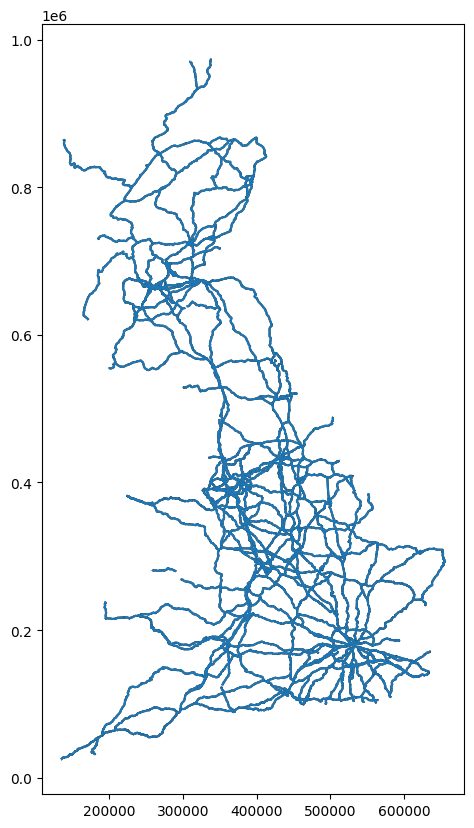

In [32]:
fig, ax = plt.subplots(figsize=(8, 10))

gdf_short_roads.plot(ax=ax, color='k')
gdf_merged.plot(ax=ax)

plt.show()

Save results to file:

In [33]:
gdf_merged[['function', 'geometry']].to_file('major_roads_with_short_names_merged.geojson')

File size is 19MB. A bit smaller than the starting point.

## Set precision

In [48]:
gdf_precision = gdf_merged.copy()

gdf_precision['geometry'] = gdf_precision['geometry'].set_precision(grid_size=1000)
gdf_precision['geometry'] = gdf_precision['geometry'].remove_repeated_points()

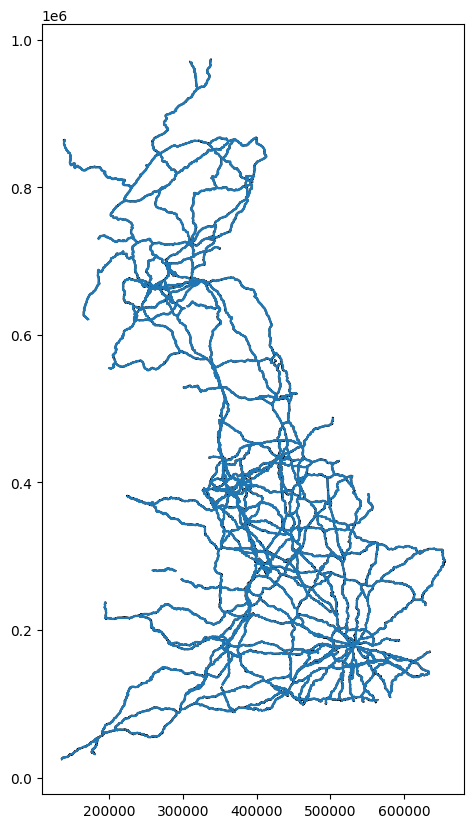

In [49]:
fig, ax = plt.subplots(figsize=(8, 10))

gdf_merged.plot(ax=ax, color='k')
gdf_precision.plot(ax=ax)

plt.show()

Save results to file:

In [50]:
gdf_precision[['function', 'geometry']].to_file('major_roads_with_short_names_merged_precision.geojson')

File size is 1MB. That'll do!!

## Remove points

In [41]:
gdf_roads = gdf_merged.copy()

# Keep only every sth point:
s = 3

# Convert Linestring to x and y coords:
x_lists = []
y_lists = []
for i in gdf_roads.index:
    geo = gdf_roads.loc[i, 'geometry']
    if geo.geom_type == 'LineString':
        x, y = geo.coords.xy
        x = list(x)
        y = list(y)
        if len(x) > s:
            x = x[::s]
            x.append(list(x)[-1])
            y = y[::s]
            y.append(list(y)[-1])
        x_lists.append(x)
        y_lists.append(y)
    elif geo.geom_type == 'MultiLineString':
        x_multi = []
        y_multi = []
        for g in geo.geoms:
            x, y = g.coords.xy
            x = list(x)
            y = list(y)
            if len(x) > s:
                x = x[::s]
                x.append(list(x)[-1])
                y = y[::s]
                y.append(list(y)[-1])
            x_multi += x + [None]
            y_multi += y + [None]
        x_lists.append(np.array(x_multi))
        y_lists.append(np.array(y_multi))
    else:
        # ???
        x_lists.append([])
        y_lists.append([])
gdf_roads['x'] = x_lists
gdf_roads['y'] = y_lists

In [42]:
gdf_roads.head().T

roadNumber,A1,A1(M),A10,A11,A12
function,A Road,Motorway,A Road,A Road,A Road
geometry,"MULTILINESTRING Z ((325846.71 674006.48 0, 325...",MULTILINESTRING Z ((421602.19 505924.220000000...,"MULTILINESTRING Z ((532556.15 192610.27 0, 532...","MULTILINESTRING Z ((533740.06 181263.95 0, 533...",MULTILINESTRING Z ((537073.98 185270.050000000...
x,"[325846.71, 325890.48, 325909.55, 325937.28, 3...","[421602.19, 421577.19, 421529.16000000003, 421...","[532556.15, 532543.21, 532524.51, 532519.23, 5...","[533740.06, 533775.0, 533819.96, 533840.63, 53...","[537073.98, 536995.25, 536958.9, 536935.14, 53..."
y,"[674006.48, 674020.6900000001, 674026.16, 6740...","[505924.22000000003, 505778.69, 505678.06, 505...","[192610.27, 192601.76, 192583.16, 192573.16, 1...","[181263.95, 181283.5, 181310.24, 181323.63, 18...","[185270.05000000002, 185195.25, 185170.18, 185..."


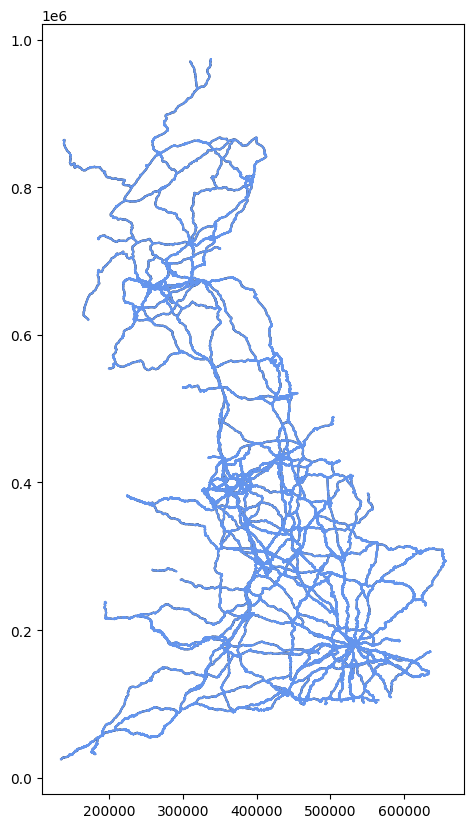

In [43]:
fig, ax = plt.subplots(figsize=(8, 10))

gdf_short_roads.plot(ax=ax, color='k')
for i in gdf_roads.index:
    ax.plot(
        gdf_roads.loc[i, 'x'],
        gdf_roads.loc[i, 'y'],
        color='CornflowerBlue'
    )

plt.show()

In [44]:
gdf_roads[['function', 'geometry']].to_file('major_roads_with_short_names_merged_remove3.geojson')

This doesn't reduce the file size at all. The maps look very similar too.

## Round points to the nearest X km and remove duplicates

In [181]:
from shapely import multilinestrings, linestrings

In [34]:
gdf_roads = gdf_merged.copy()

dp = -3

# Convert Linestring to x and y coords:
x_lists = []
y_lists = []
for i in gdf_roads.index:
    geo = gdf_roads.loc[i, 'geometry']
    if geo.geom_type == 'LineString':
        x, y = geo.coords.xy
        x = np.round(list(x), dp)
        y = np.round(list(y), dp)
        # Remove repeats:
        xdiff = np.diff(x, prepend=x[0])
        ydiff = np.diff(y, prepend=y[0])
        points_to_keep = (xdiff != 0.0) & (ydiff != 0.0)
        inds_to_keep = np.where(points_to_keep == True)
        x = np.array(x)[np.append(0, inds_to_keep)]
        y = np.array(y)[np.append(0, inds_to_keep)]
        # Store:
        x_lists.append(x)
        y_lists.append(y)
    elif geo.geom_type == 'MultiLineString':
        x_multi = []
        y_multi = []
        for g in geo.geoms:
            x, y = g.coords.xy
            x = np.round(list(x), dp)
            y = np.round(list(y), dp)
            # Store:
            x_multi += list(x)  # list(np.append(x, None))
            y_multi += list(y)  # list(np.append(y, None))
        # Remove repeats:
        x = x_multi
        y = y_multi
        xdiff = np.diff(x, prepend=x[0])
        ydiff = np.diff(y, prepend=y[0])
        points_to_keep = (xdiff != 0.0) & (ydiff != 0.0)
        inds_to_keep = np.where(points_to_keep == True)
        x = np.array(x)[np.append(0, inds_to_keep)]
        y = np.array(y)[np.append(0, inds_to_keep)]
        # Store:
        x_lists.append(np.array(x))
        y_lists.append(np.array(y))
    else:
        # ???
        x_lists.append([])
        y_lists.append([])
gdf_roads['x'] = x_lists
gdf_roads['y'] = y_lists

In [35]:
gdf_roads

,function,geometry,x,y
roadNumber,,,,
A1,A Road,"MULTILINESTRING Z ((325846.71 674006.48 0, 325...","[326000.0, 348000.0, 348000.0, 365000.0, 35900...","[674000.0, 674000.0, 674000.0, 677000.0, 67600..."
A1(M),Motorway,"MULTILINESTRING Z ((421602.19 505924.22 0, 421...","[422000.0, 422000.0, 423000.0, 426000.0, 42300...","[506000.0, 505000.0, 499000.0, 518000.0, 49900..."
A10,A Road,"MULTILINESTRING Z ((532556.15 192610.27 0, 532...","[533000.0, 533000.0, 534000.0, 535000.0, 53500...","[193000.0, 193000.0, 195000.0, 200000.0, 20000..."
A11,A Road,"MULTILINESTRING Z ((533740.06 181263.95 0, 533...","[534000.0, 551000.0, 552000.0, 551000.0, 55200...","[181000.0, 245000.0, 249000.0, 247000.0, 24900..."
A12,A Road,"MULTILINESTRING Z ((537073.98 185270.05 0, 537...","[537000.0, 541000.0, 538000.0, 541000.0, 54500...","[185000.0, 188000.0, 183000.0, 188000.0, 18800..."
...,...,...,...,...
M77,Motorway,"MULTILINESTRING Z ((245842.16 642251.23 0, 245...","[246000.0, 247000.0, 248000.0, 252000.0, 25200...","[642000.0, 645000.0, 646000.0, 654000.0, 65400..."
M8,Motorway,"MULTILINESTRING Z ((240735.14 672978.82 0, 240...","[241000.0, 245000.0, 242000.0, 245000.0, 24700...","[673000.0, 671000.0, 673000.0, 671000.0, 66600..."
M80,Motorway,"MULTILINESTRING Z ((262525.5 666652.59 0, 2625...","[263000.0, 263000.0, 263000.0, 263000.0, 26400...","[667000.0, 667000.0, 667000.0, 667000.0, 66800..."


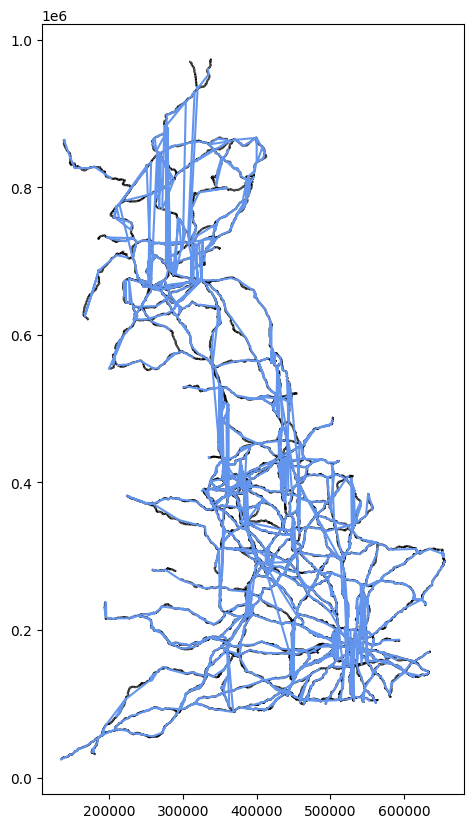

In [36]:
fig, ax = plt.subplots(figsize=(8, 10))

gdf_short_roads.plot(ax=ax, color='k')
for i in gdf_roads.index:
    ax.plot(
        gdf_roads.loc[i, 'x'],
        gdf_roads.loc[i, 'y'],
        color='CornflowerBlue'
    )

plt.show()

In [172]:
x

array([327000., 327000., 327000., 327000., 327000., 327000., 327000.,
       327000.])

In [173]:
np.append(x, None)

array([327000.0, 327000.0, 327000.0, 327000.0, 327000.0, 327000.0,
       327000.0, 327000.0, None], dtype=object)

In [168]:
np.round(674382.5700, -3)

674000.0